# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os

current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

Confirm new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Loading Dataset

In [38]:
import pandas as pd

df_train = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df_train.head()
import pandas as pd

df_test = pd.read_parquet('outputs/datasets/cleaned/test.parquet.gzip')
df_train.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
618,618,1828,0,2,Av,48,Unf,1774,0,774,...,90,452,108,5,9,1822,0,2007,2007,314813
870,870,894,0,2,No,0,Unf,894,0,308,...,60,0,0,5,5,894,0,1962,1962,109500
92,92,964,0,2,No,713,ALQ,163,0,432,...,80,0,0,7,5,876,0,1921,2006,163500
817,817,1689,0,3,No,1218,GLQ,350,0,857,...,70,148,59,5,8,1568,0,2002,2002,271000
302,302,1541,0,3,No,0,Unf,1541,0,843,...,118,150,81,5,7,1541,0,2001,2002,205000


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we drop features:

In [39]:
drop_features = ['Unnamed: 0']
df_train.drop(columns=drop_features, inplace=True)
df_test.drop(columns=drop_features, inplace=True)

## Splitting to data and test dataframe

In [40]:
# Identify the target variable column name
target_column = 'SalePrice'

# Extract the target variable
y_train = df_train[target_column]
y_test = df_test[target_column]

# Remove the target variable from the DataFrame to create the feature DataFrame
X_train = df_train.drop(columns=[target_column])
X_test = df_test.drop(columns=[target_column])


## Machine Learning

### Pre-Transformations

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import category_encoders as ce

# Define custom FeatureCreator class
class FeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Fit method could calculate and store statistics, if needed
        return self

    def transform(self, X):
        X = X.copy()  # Work on a copy of the data
        if 'BsmtFinType1' in X.columns and 'BsmtFinSF1' in X.columns:
            X['BsmtFinType1_BsmtFinSF1'] = X['BsmtFinType1'] * X['BsmtFinSF1']
        if 'BsmtExposure' in X.columns and 'TotalBsmtSF' in X.columns:
            X['BsmtExposure_TotalBsmtSF'] = X['BsmtExposure'] * X['TotalBsmtSF']
        if 'GarageArea' in X.columns and 'GarageFinish' in X.columns:
            X['GarageArea_GarageFinish'] = X['GarageArea'] * X['GarageFinish']
        return X

# Mapping and encoder setup
encoding_dict = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
}

ordinal_encoder = ce.OrdinalEncoder(mapping=[
    {'col': k, 'mapping': v} for k, v in encoding_dict.items()
])

# Pipeline setup
pre_feature_transformations = Pipeline(steps=[
    ('ordinal_encoder', ordinal_encoder),  # Custom categorical encoding
    ('feature_creator', FeatureCreator())  # Custom feature creation
])

In [42]:
# Testing transformations for errors and what is the return
X_train_transformed = pre_feature_transformations.fit_transform(X_train)
type(X_train_transformed)

pandas.core.frame.DataFrame

### Features - Columns transformations

In [43]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from feature_engine.transformation import BoxCoxTransformer


# Custom transformer for DataFrame that applies transformation to specified columns
class DFColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X[self.columns], y)
        return self

    def transform(self, X):
        X = X.copy()
        X.loc[:, self.columns] = self.transformer.transform(X[self.columns])
        return X

# Define the columns for each transformation type
yeo_johnson_features = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtUnfSF',
                        'EnclosedPorch', 'GarageFinish', 'LotArea', 'MasVnrArea', 'OpenPorchSF',
                        'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF']
power_features = ['BsmtFinSF1', 'LotFrontage']
box_cox_features = ['GrLivArea']

# Create transformers for each group of features
yeo_johnson_transformer = DFColumnTransformer(PowerTransformer(method='yeo-johnson', standardize=True), yeo_johnson_features)
power_transformer = DFColumnTransformer(PowerTransformer(method='yeo-johnson', standardize=True), power_features)  # Using Yeo-Johnson for simplicity
box_cox_transformer = DFColumnTransformer(PowerTransformer(method='box-cox', standardize=True), box_cox_features)

# Combine all transformers into a single pipeline
feature_transformer = Pipeline([
    ('yeo_johnson', yeo_johnson_transformer),
    ('power', power_transformer),
    ('box_cox', box_cox_transformer)
])


### Features-Columns Post Transformations

In [44]:
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Define the columns for Winsorization
winsorize_features = [
    '1stFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtUnfSF', 'GarageYrBlt',
    'GrLivArea', 'OverallCond', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'LotArea', 'LotFrontage'
]

# Initialize the Winsorizer transformer
winsorize_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsorize_features)

# Create the pipeline
post_feature_transformer = Pipeline([
    ('winsorize', winsorize_transformer),
    #('features_scaler', StandardScaler())
])



### Main Pipeline 

In [45]:
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt
from sklearn.feature_selection import SelectFromModel
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder

def create_pipeline(model):
    """Creates a comprehensive pipeline including preprocessing, transformations, and model fitting."""
    main_pipeline = Pipeline([
        ('pre_transformations', pre_feature_transformations),          # Preprocessing steps
        ('transformations', feature_transformer),                  # Transformations
        ('post_transformations', post_feature_transformer),       # Post-transformations
        ("feat_selection", SelectFromModel(model)),
        ('model', model)                                      # Final model
    ])

    return main_pipeline

## ML Pipeline for Modeling and Hyperparameters Optimization

This is custom Class Hyperparameter Optimization

In [46]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=2, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = create_pipeline(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Grid Search CV

For this time being we will use default hyperparameters, just to select best algorithms

In [47]:
### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Running Grid Search CV

In [48]:
### Results Inspection
initial_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
initial_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=25)


Running GridSearchCV for LinearRegression 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Running GridSearchCV for XGBRegressor 

Fitting 25 folds for each of 1 candidates, totalling 25 fits


In [49]:
import numpy as np

grid_search_summary, grid_search_pipelines = initial_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.567119,0.78698,0.91176,0.076872
3,ExtraTreesRegressor,-0.464717,0.779606,0.941458,0.261092
5,GradientBoostingRegressor,-0.558475,0.735691,0.896532,0.279022
4,AdaBoostRegressor,-0.482185,0.714521,0.862846,0.263397
2,RandomForestRegressor,-0.129366,0.699938,0.908877,0.195335
6,XGBRegressor,0.240679,0.668811,0.882029,0.146292
1,DecisionTreeRegressor,-0.193122,0.600111,0.863967,0.223213


We can see that LinearRegression shows most promising results, mean = 0.78698, ExtraTreesRegressor is also high 0.779606
Now we will add extra HyperParameters

In [50]:
from sklearn.linear_model import LinearRegression

# Dictionary containing the model instances
models_tune_search_1 = {
    "LinearRegression": LinearRegression(),
}

# Dictionary containing hyperparameters for tuning
params_tune_search_1 = {
    "LinearRegression": {
        'model__fit_intercept': [True, False],  # Whether to calculate the intercept for this model
        'model__n_jobs': [None, -1],            # Number of CPU cores used for the computations
        'model__positive': [True, False],       # Forces the coefficients of the model to be positive
        'model__copy_X': [True, False]          # If True, X will be copied; otherwise, it may be overwritten.
    }
}


In [53]:
search_tuned_1 = HyperparameterOptimizationSearch(models=models_tune_search_1, params=params_tune_search_1)
search_tuned_1.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=25)


Running GridSearchCV for LinearRegression 

Fitting 25 folds for each of 16 candidates, totalling 400 fits


In [54]:
models_tune_search_summary_1, models_tune_search_pipeline_1 = search_tuned_1.score_summary(sort_by='mean_score')
models_tune_search_summary_1

,estimator,min_score,mean_score,max_score,std_score,model__copy_X,model__fit_intercept,model__n_jobs,model__positive
0,LinearRegression,0.567119,0.788485,0.91176,0.076602,True,True,None,True
2,LinearRegression,0.567119,0.788485,0.91176,0.076602,True,True,-1,True
8,LinearRegression,0.567119,0.788485,0.91176,0.076602,False,True,None,True
10,LinearRegression,0.567119,0.788485,0.91176,0.076602,False,True,-1,True
1,LinearRegression,0.567119,0.78698,0.91176,0.076872,True,True,None,False
3,LinearRegression,0.567119,0.78698,0.91176,0.076872,True,True,-1,False
9,LinearRegression,0.567119,0.78698,0.91176,0.076872,False,True,None,False
11,LinearRegression,0.567119,0.78698,0.91176,0.076872,False,True,-1,False
4,LinearRegression,0.527793,0.752187,0.901958,0.083212,True,False,None,True
6,LinearRegression,0.527793,0.752187,0.901958,0.083212,True,False,-1,True


Yay, we managed to increase mean from 0.832868 to 0.846216, not a lot but still something.

Selecting best model

Parameters for best model

In [55]:
LinearRegression_best_parameters = models_tune_search_pipeline_1[models_tune_search_summary_1.iloc[0, 0]].best_params_
LinearRegression_best_parameters

{'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__positive': True}

In [56]:
LinearRegression_regressor_pipeline = models_tune_search_pipeline_1[models_tune_search_summary_1.iloc[0, 0]].best_estimator_
LinearRegression_regressor_pipeline

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                 Pipeline(steps=[('winsorize',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables=['1stFlrSF',
                                                        'BedroomAbvGr',
                                                        'BsmtExposure',
                                                        'BsmtUnfSF',
                                                        'GarageYrBlt',
                                                        'GrLivArea',
                                                        'OverallCond',
                                                        'OverallQual',
                                                        'YearBuilt',
                                                        'TotalBsmtSF',
                                                        'LotArea',
                                                        'LotFrontage']))])),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression(positive=True))])

## Accessing Feature Importance

* These are the 8 most important features in descending order. The model was trained on them: 
['OverallQual', 'KitchenQual', 'GrLivArea', 'TotalBsmtSF', 'LotArea', 'BsmtExposure', 'GarageFinish', 'OverallCond']


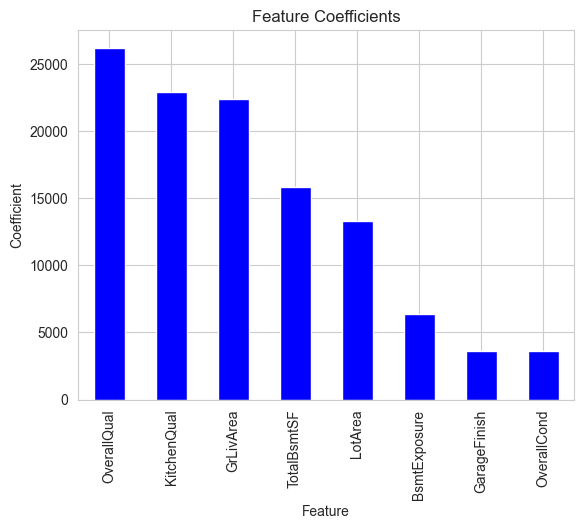

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Assume 'lasso_best_regressor_pipeline' and 'X_train' are defined earlier in your code
try:
    data_cleaning_feat_eng_steps = 3  # Number of data cleaning and feature engineering steps
    transformer_pipeline = Pipeline(LinearRegression_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])

    # Ensure the pipeline up to this point consists only of transformers
    if not hasattr(transformer_pipeline, 'transform'):
        raise AttributeError("The sub-pipeline does not support transform operation.")

    X_transformed = transformer_pipeline.transform(X_train)
    columns_after_data_cleaning_feat_eng = X_transformed.columns

    feature_support_mask = LinearRegression_regressor_pipeline['feat_selection'].get_support()
    best_features = columns_after_data_cleaning_feat_eng[feature_support_mask].to_list()

    # DataFrame to display feature coefficients
    df_feature_coefficients = pd.DataFrame({
        'Feature': columns_after_data_cleaning_feat_eng[feature_support_mask],
        'Coefficient': LinearRegression_regressor_pipeline['model'].coef_
    }).sort_values(by='Coefficient', ascending=False)

    print(f"* These are the {len(best_features)} most important features in descending order. "
          f"The model was trained on them: \n{df_feature_coefficients['Feature'].to_list()}")

    df_feature_coefficients.plot(kind='bar', x='Feature', y='Coefficient', color='blue', legend=None)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient')
    plt.title('Feature Coefficients')
    plt.show()

except AttributeError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


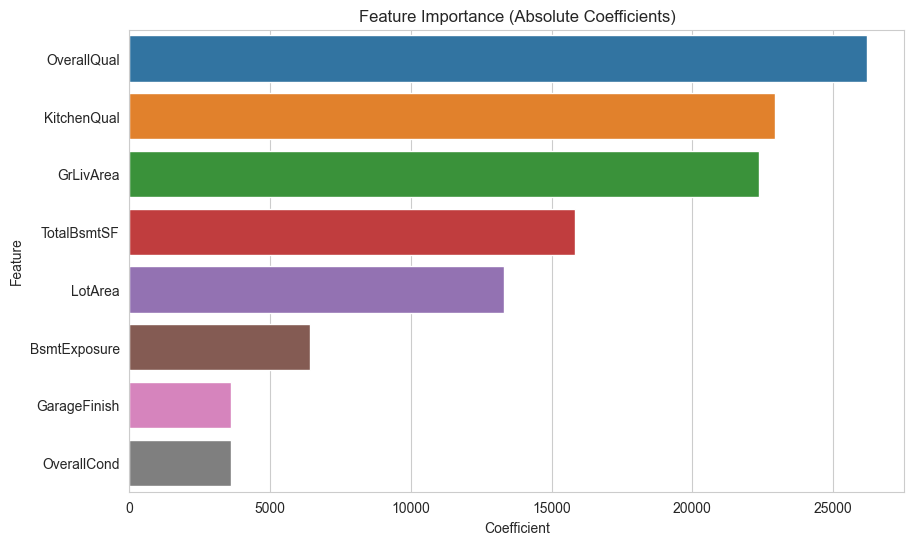

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming lasso_best_regressor_pipeline is a Pipeline object containing the Lasso model
LinearRegression_model = LinearRegression_regressor_pipeline['model']

# Get feature names from the pipeline
feature_names = columns_after_data_cleaning_feat_eng[LinearRegression_regressor_pipeline['feat_selection'].get_support()]

# Get coefficients from the Lasso model
coefficients = LinearRegression_model.coef_

# Create a DataFrame to store feature names and coefficients
df_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort coefficients by absolute value
df_coefficients['Abs_Coefficient'] = abs(df_coefficients['Coefficient'])
df_coefficients_sorted = df_coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Plot coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance (Absolute Coefficients)')
plt.show()


## Evaluating Model on Train and Test Sets

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # Train plot
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], color='blue')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Red line y=x
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set Performance")

    # Test plot
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Red line y=x
    axes[1].set_xlabel("Actual Values")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set Performance")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.8
Mean Absolute Error: 23707.662


* Test Set
R2 Score: 0.728
Mean Absolute Error: 27647.319




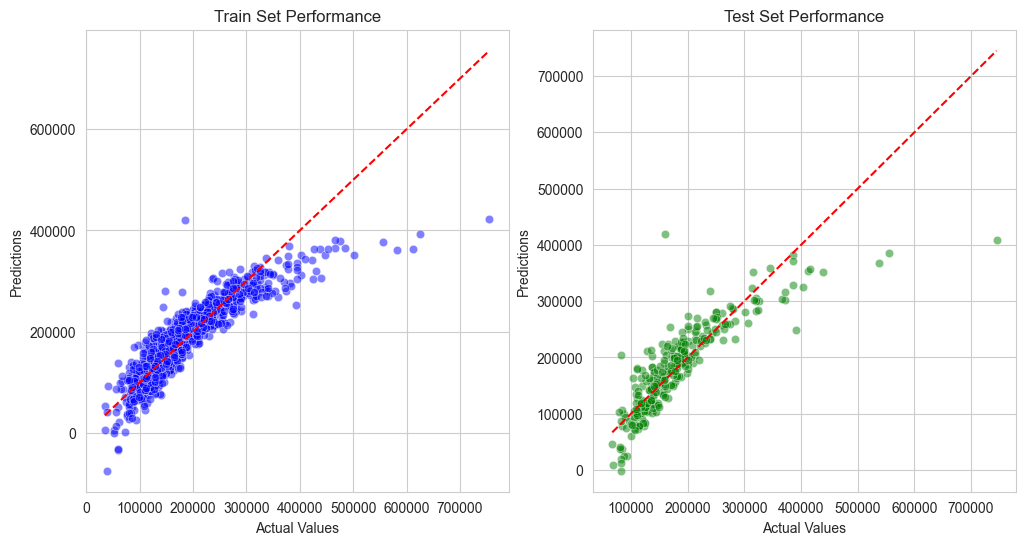

In [60]:
regression_performance(X_train, y_train, X_test, y_test, LinearRegression_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, LinearRegression_regressor_pipeline)

## Results are way better than previous Hypothesis, but we can see model is Overfitted !

Let's try ExtraTreesRegressor

In [63]:
models_tune_search_2 = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

params_tune_search_2 = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [100,300, 600],
        'model__max_depth': [3,10,20,None],
        'model__min_samples_split': [8, 16],
    }
}

In [64]:
search_tuned_2 = HyperparameterOptimizationSearch(models=models_tune_search_2, params=params_tune_search_2)
search_tuned_2.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=25)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 25 folds for each of 24 candidates, totalling 600 fits


In [65]:
models_tune_search_summary_2, models_tune_search_pipeline_2 = search_tuned_2.score_summary(sort_by='mean_score')
models_tune_search_summary_2

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
21,ExtraTreesRegressor,0.24552,0.823553,0.942778,0.128688,None,16,100
15,ExtraTreesRegressor,0.250415,0.823549,0.942806,0.127995,20,16,100
22,ExtraTreesRegressor,0.237681,0.822014,0.944695,0.130134,None,16,300
16,ExtraTreesRegressor,0.23562,0.821768,0.944538,0.130633,20,16,300
17,ExtraTreesRegressor,0.231249,0.82121,0.943633,0.131235,20,16,600
23,ExtraTreesRegressor,0.237684,0.821179,0.943857,0.130037,None,16,600
11,ExtraTreesRegressor,0.232951,0.820952,0.939869,0.131075,10,16,600
10,ExtraTreesRegressor,0.225044,0.820327,0.941493,0.132513,10,16,300
9,ExtraTreesRegressor,0.196077,0.818215,0.942138,0.137406,10,16,100
8,ExtraTreesRegressor,0.010729,0.810388,0.939979,0.172246,10,8,600


In [66]:
ExtraTreesRegressor_best_parameters = models_tune_search_pipeline_2[models_tune_search_summary_2.iloc[0, 0]].best_params_
ExtraTreesRegressor_best_parameters

{'model__max_depth': None,
 'model__min_samples_split': 16,
 'model__n_estimators': 100}

In [67]:
ExtraTreesRegressor_regressor_pipeline = models_tune_search_pipeline_2[models_tune_search_summary_2.iloc[0, 0]].best_estimator_
ExtraTreesRegressor_regressor_pipeline

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables=['1stFlrSF',
                                                        'BedroomAbvGr',
                                                        'BsmtExposure',
                                                        'BsmtUnfSF',
                                                        'GarageYrBlt',
                                                        'GrLivArea',
                                                        'OverallCond',
                                                        'OverallQual',
                                                        'YearBuilt',
                                                        'TotalBsmtSF',
                                                        'LotArea',
                                                        'LotFrontage']))])),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(min_samples_split=16, random_state=0))])

* These are the 7 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'KitchenQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']


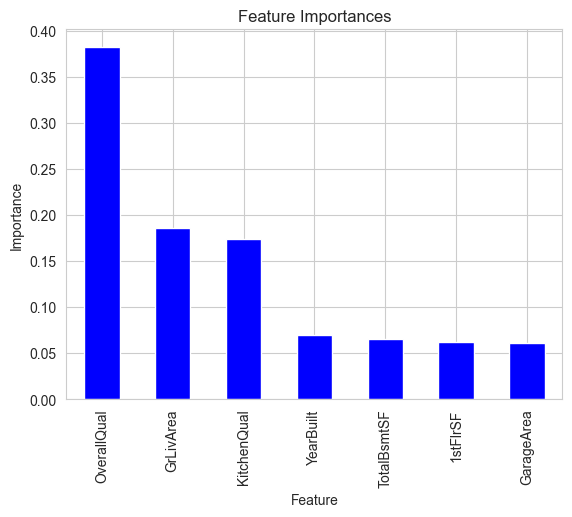

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Assume 'ExtraTreesRegressor_regressor_pipeline' and 'X_train' are defined earlier in your code
try:
    data_cleaning_feat_eng_steps = 3  # Number of data cleaning and feature engineering steps in the pipeline
    transformer_pipeline = Pipeline(ExtraTreesRegressor_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])

    # Ensure the pipeline up to this point consists only of transformers
    if not hasattr(transformer_pipeline, 'transform'):
        raise AttributeError("The sub-pipeline does not support transform operation.")

    X_transformed = transformer_pipeline.transform(X_train)
    columns_after_data_cleaning_feat_eng = X_transformed.columns

    feature_support_mask = ExtraTreesRegressor_regressor_pipeline['feat_selection'].get_support()
    best_features = columns_after_data_cleaning_feat_eng[feature_support_mask].to_list()

    # DataFrame to display feature importances
    df_feature_importances = pd.DataFrame({
        'Feature': columns_after_data_cleaning_feat_eng[feature_support_mask],
        'Importance': ExtraTreesRegressor_regressor_pipeline['model'].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"* These are the {len(best_features)} most important features in descending order. "
          f"The model was trained on them: \n{df_feature_importances['Feature'].to_list()}")

    df_feature_importances.plot(kind='bar', x='Feature', y='Importance', color='blue', legend=None)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()

except AttributeError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


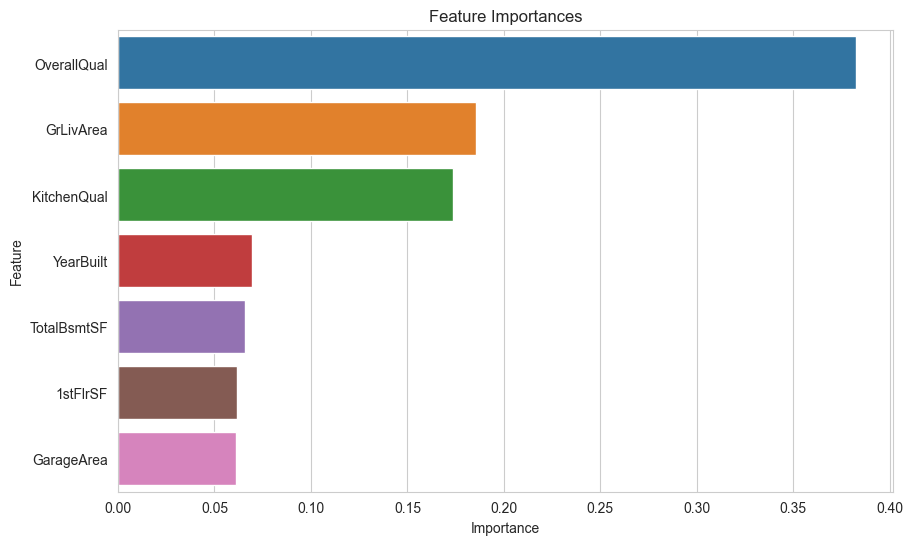

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ExtraTreesRegressor_regressor_pipeline is a Pipeline object containing the ExtraTreesRegressor model
ExtraTreesRegressor_model = ExtraTreesRegressor_regressor_pipeline['model']

# Get feature names from the pipeline
feature_names = columns_after_data_cleaning_feat_eng[ExtraTreesRegressor_regressor_pipeline['feat_selection'].get_support()]

# Get feature importances from the ExtraTreesRegressor model
importances = ExtraTreesRegressor_model.feature_importances_

# Create a DataFrame to store feature names and their importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort importances by their absolute values (though all will be positive here)
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importances_sorted)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.917
Mean Absolute Error: 14004.479


* Test Set
R2 Score: 0.806
Mean Absolute Error: 20408.138




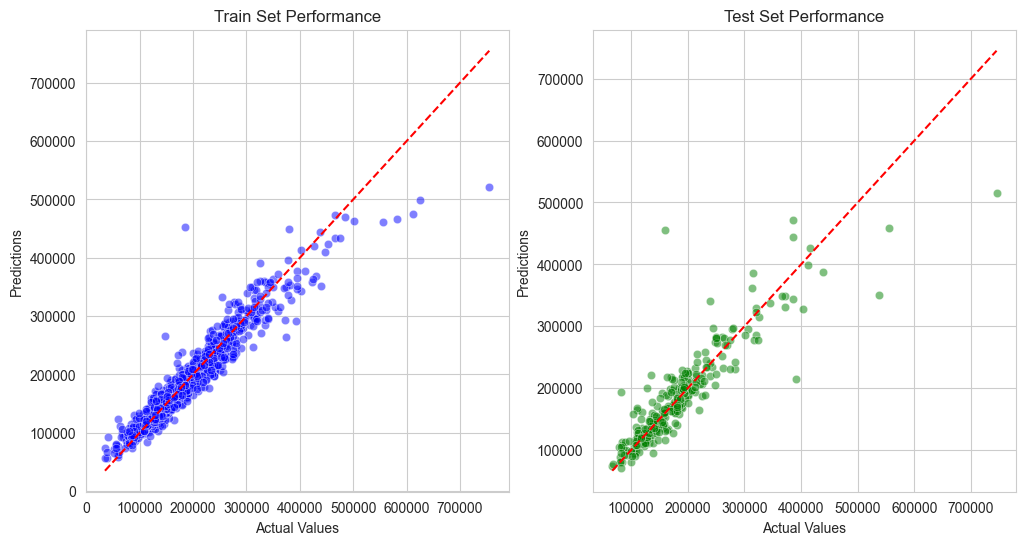

In [79]:
regression_performance(X_train, y_train, X_test, y_test, ExtraTreesRegressor_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, ExtraTreesRegressor_regressor_pipeline)

## Strategies to Improve Model Performance and Reduce Overfitting

### 1. Evaluate and Adjust Data Transformations
- **Goal**: Ensure the model is not learning from noise or overly complex transformations.
- **Actions**:
  - Review current transformations for complexity and relevance.
  - Simplify transformations to focus on significant features.
  - Test removal or addition of transformations based on their impact on model performance.

### 2. Implement Feature Scaling
- **Goal**: Balance the influence of features in the model by ensuring features are on a comparable scale.
- **Actions**:
  - Apply `StandardScaler` for features with a normal distribution.
  - Evaluate the impact of scaling on the model


### 3. Monitor and Iterate
- **Goal**: Achieve the best possible model performance through continuous improvement.
- **Actions**:
  - Regularly review model outputs and performance metrics.
  - Adapt strategies as new data becomes available or as project requirements evolve.
  - Keep abreast of new techniques or algorithms that might improve model performance.
